In [1]:
import pandas as pd
import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]

import networkx as nx #graphs
cwd = os.getcwd()

from ExMAS.utils import inData as inData
from dotmap import DotMap


In [2]:
df1 = pd.read_csv('polygon1.csv') #demografia 
df = df1.loc[df1.index.repeat(df1.ogolem)].reset_index(drop=True) #repeat Rows N times (equal "ogolem"): N Rows = N people 
params = ExMAS.utils.get_config('default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [3]:
len(df)

4550

In [33]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['y'], row['x'])), axis = 1) 
    inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests

    my_requests = inData.requests
    my_requests.destination = hub[1]
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1)
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests = inData.requests
    inData.requests = my_requests
    # inData.requests.to_csv("check.csv")
    inData = ExMAS.main(inData, params)
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    KPIs.to_csv(f'res/1/KPI_{hub[0]}_{frac}_{repl}.csv') #res/
    return KPIs



params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.003
params.pax_delay = 15
params.max_degree = 4
params.price = 1.5
results = dict()
 
#    hubs 

    
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.01844, 19.88948])),
        ('hub2', ox.get_nearest_node(inData.G,[50.030129, 19.913131]))]#('hub1', ox.get_nearest_node(inData.G,[50.01844, 19.88948])),





for frac in  [0.0005]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 0.0005 1
07-02-24 11:12:42-INFO-Initializing pairwise trip shareability between 2 and 2 trips.
07-02-24 11:12:42-INFO-creating combinations
07-02-24 11:12:42-INFO-2	 nR*(nR-1)
07-02-24 11:12:42-INFO-Reduction of feasible pairs by 50.00%
07-02-24 11:12:42-INFO-Degree 2 	Completed
07-02-24 11:12:42-INFO-trips to extend at degree 2 : 2
07-02-24 11:12:42-INFO-At degree 2 feasible extensions found out of 0 searched
07-02-24 11:12:42-INFO-Degree 3 	Completed
07-02-24 11:12:42-INFO-No more trips to exted at degree 3
07-02-24 11:12:42-INFO-Matching 2 trips to 4 rides in order to minimize u_veh
07-02-24 11:12:42-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,404 
reduced by matching to:                  803
07-02-24 11:12:42-INFO-Calculations  completed
07-02-24 11:12:42-INFO-DotMap(VehHourTrav=788, VehHourTrav_ns=1404, PassHourTrav=1482, PassHourTrav_ns=1404, PassUtility=16.4337, PassUtility_ns=16.8615, mean_lambda=0.42806267806267806, revenue_s=1684.80000000000

# len(df)

In [7]:
results = {}
for num, frac, rep in list(itertools.product([1,2], [0.001, 0.002, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03, 0.05], range(10))):
    results[str((num, frac, rep))] = pd.read_csv('res/1/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/1/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["hub"]
# print(dfr)
dfr.to_csv('res/1/result1_D0-05(10).csv')

In [8]:
pd.read_csv('res/1/result1_D0-05(10).csv', header=None).T.to_csv('res/1/resultT1_D0-05(10).csv', header=False, index=False)

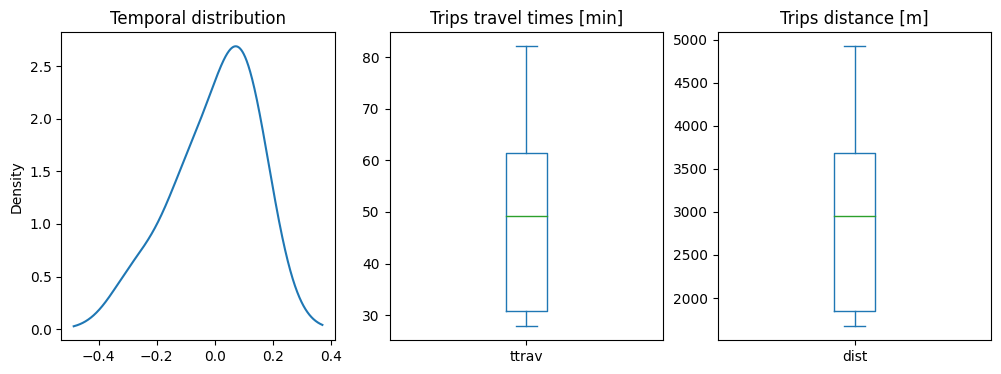

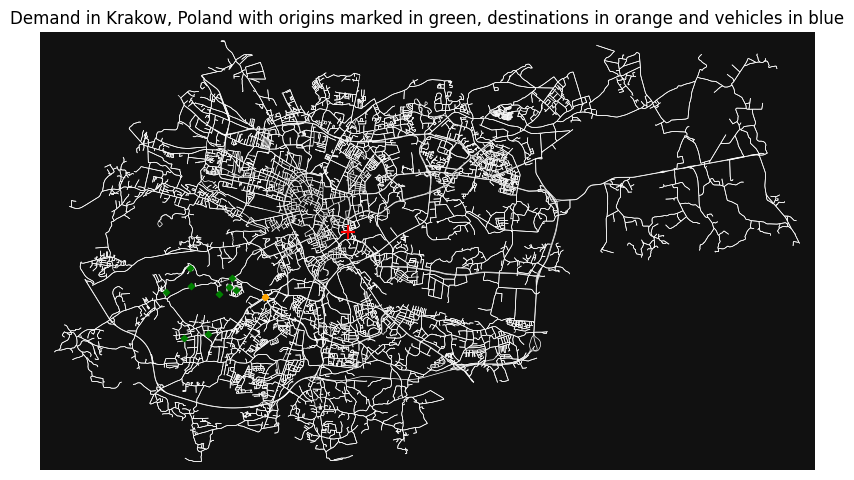

In [16]:
ExMAS.utils.plot_demand(inData, params)